# `graphmix` examples

This notebook provides several examples to demonstrate the usage of
the `graphmix` package.

## Install `graphmix`


## Import `graphmix` into your code

Graphmix uses a chemical registry to store chemical data. The chemical registry
is a SQLite database that stores chemical data from PubChem. By default, the
database is located at `~/.graphmix/chemicals.db`. If the database does not exist, 
it will be created when you first initialize a `ChemicalRegistry` object. You can 
optionally pass a database path to the `ChemicalRegistry` constructor to specify a 
different location for the database.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import graphmix as gm

chem_reg = gm.ChemicalRegistry()


## Examples

### Example 1: Get chemical data from PubChem

To use a chemical, initialize it by calling `chem_reg.Chemical('chemical_name')`. This will do one of three things:

1. If the chemical is already in the database, it will load the data from the database.
2. If the chemical is not in the database, it will fetch the data from PubChem and store it in the database.
3. If the chemical is not in the database and cannot be found on PubChem, it will raise a `ValueError`.

In [5]:
etoh = chem_reg.Chemical('Ethanol')

etoh

Chemical(name='Ethanol', formula='C2H6O', smiles='CCO', molar_mass=<Quantity(46.07, 'gram / mole')>)

### Example 2: Create a solution

Chemicals are more fun with mixed with other chemicals.

To create a solution, give it a clever name and add chemicals to it.

Importantly, `graphmix` uses and extends the Pint library for Quantities. The following extensions are added

1. Pydantic integration for full support as part of pydantic's `BaseModel`s
2. The `DimQuantity` class which provides forced dimensions of Quantities. This includes `MolarConcentration`, `Volume`, `Percent`, and more.

Let's create a 5 mg/mL solution of Nile Red in Ethanol. We will use Q_ from graphmix as shorthand for initializing Quantities.

In [8]:
from graphmix import Q_

nile_red = chem_reg.Chemical('Nile Red')
nile_red


Chemical(name='Nile Red', formula='C20H18N2O2', smiles='CCN(CC)C1=CC2=C(C=C1)N=C3C4=CC=CC=C4C(=O)C=C3O2', molar_mass=<Quantity(318.4, 'gram / mole')>)

In [15]:
stock_solution = gm.Solution(
    name="Nile Red in Ethanol",
).with_component(
    nile_red,
    Q_(5, 'mg/mL')
    # solutes are described as mass concentrations or molar concentrations.
).with_component(
    etoh,
    Q_(100, "%")
    # solvents are described as percentages, we are not interested in the volume of the solution at this point, just its composition.
)

`graphmix` uses directed graphs to represent solutions. We can visualize this using `gm.plot_graph`:

<Axes: >

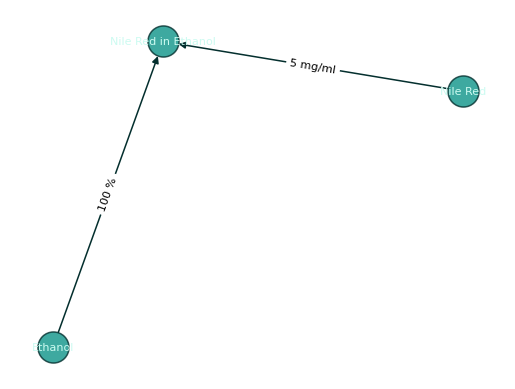

In [11]:
gm.plot_graph(stock_solution.G)

For the directed graphs, `graphmix` extends networkx's `DiGraph` to also work with pydantic's `BaseModel`s. This allows for easy serialization and deserialization of the graph structure which facilitates database storage and retrieval, as well as easy integration with a FastAPI server.

In [17]:
print(stock_solution.model_dump_json(indent=2))

{
  "name": "Nile Red in Ethanol",
  "G": {
    "directed": true,
    "multigraph": false,
    "graph": {},
    "nodes": [
      {
        "id": "Nile Red"
      },
      {
        "id": "Nile Red in Ethanol"
      },
      {
        "id": "Ethanol"
      }
    ],
    "links": [
      {
        "concentration": "5 mg/ml",
        "source": "Nile Red",
        "target": "Nile Red in Ethanol"
      },
      {
        "concentration": "100 %",
        "source": "Ethanol",
        "target": "Nile Red in Ethanol"
      }
    ]
  },
  "components": {
    "Nile Red": {
      "name": "Nile Red",
      "formula": "C20H18N2O2",
      "smiles": "CCN(CC)C1=CC2=C(C=C1)N=C3C4=CC=CC=C4C(=O)C=C3O2",
      "molar_mass": "318.4 g/mol",
      "id": null
    },
    "Ethanol": {
      "name": "Ethanol",
      "formula": "C2H6O",
      "smiles": "CCO",
      "molar_mass": "46.07 g/mol",
      "id": null
    }
  }
}


### Example 3: Dilute a solution

Now let's dilute the stock solution. For fun, lets dilute it with PBS (Phosphate Buffered Saline). First, we make the PBS solution:

<Axes: >

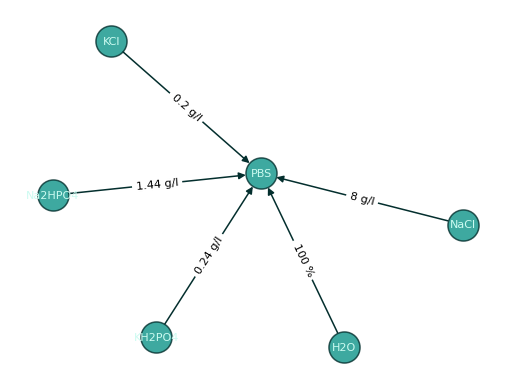

In [18]:
pbs = gm.Solution(
    name="PBS",
).with_component(
    chem_reg.Chemical('NaCl'),
    Q_(8, 'g/L')
).with_component(
    chem_reg.Chemical('KCl'),
    Q_(0.2, 'g/L')
).with_component(
    chem_reg.Chemical('Na2HPO4'),
    Q_(1.44, 'g/L')
).with_component(
    chem_reg.Chemical('KH2PO4'),
    Q_(0.24, 'g/L')
).with_component(
    chem_reg.Chemical('H2O'),
    Q_(100, "%")
)

gm.plot_graph(pbs.G)

<Axes: >

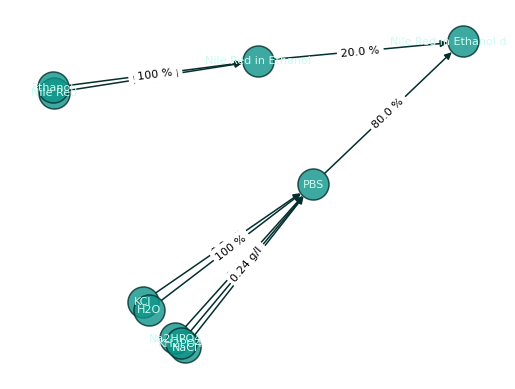

In [20]:
diluted_solution = stock_solution.dilute_with(pbs, 1 / 5)
gm.plot_graph(diluted_solution.G)

The `composition` property of a solution returns a `Composition` object that contains the makeup of each chemical in the solution. Lets make sure our solution is properly diluted:

In [23]:
stock_solution.composition.of(nile_red)

5.0 <Unit('milligram / milliliter')>

In [22]:
diluted_solution.composition.of(nile_red)

1.0 <Unit('milligram / milliliter')>

Let's dilute the diluted solution in half with water now.

<Axes: >

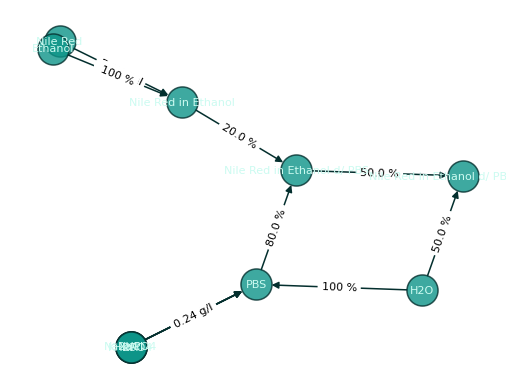

In [24]:
another_dilution = diluted_solution.dilute_with(chem_reg.Chemical('H2O'), 1 / 2)
gm.plot_graph(another_dilution.G)

In [25]:
another_dilution.composition.of(nile_red)

0.5 <Unit('milligram / milliliter')>

### TODO: Protocol example, Protocol builder example, and protocol execution example